**Importing all libraries**

In [1]:
import numpy as np 
import os
import glob
import shutil
import cv2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend as keras
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import datetime
# import tensorflow_addons as tfa

**Preparing Dataset**

In [11]:
data_dir_input = "/Unet_test_on_data"
data_dir_output = "/Unet_test_on_data-labels"
filenames = glob.glob('/Unet_test_on_data/imgs/*.jpg')
labels = glob.glob('/Unet_test_on_data-labels/imgs/*.jpg')
# for subdir, dirs, files in os.walk(images_dir):
#     #print(files)
#     for file in files:
#         filenames.append(file)

# If you want to reduce dataset number
# filenames = filenames[3200:]
# labels = labels[3200:]
        
filenames_shuffled, labels_shuffled = shuffle(filenames, labels)
filenames_shuffled_numpy = np.array(filenames_shuffled)
labels_shuffled_numpy = np.array(labels_shuffled)


X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled_numpy, labels_shuffled_numpy, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (3800,)
print(y_train.shape)           # (3800, 12)

print(X_val_filenames.shape)   # (950,)
print(y_val.shape)             # (950, 12)

# You can save these files as well. As you will be using them later for training and validation of your model.
# np.save('X_train_filenames.npy', X_train_filenames)
# np.save('y_train.npy', y_train)

# np.save('X_val_filenames.npy', X_val_filenames)
# np.save('y_val.npy', y_val)


(3200,)
(3200,)
(800,)
(800,)


**Dataset Generator for optimizing performance**

In [12]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            cv2.resize(cv2.imread(str(file_name)), (256, 256))
               for file_name in batch_x])/255.0, np.array([
                                            cv2.resize(cv2.cvtColor(cv2.imread(str(label_name)), cv2.COLOR_RGB2GRAY), (256, 256))
                                               for label_name in batch_y])/255.0

In [14]:
batch_size = 8

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)

**Preparing the U-Net model**

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

**Making the Model**

In [16]:
inputs = Input((256,256,3))
unet_model = get_unet(inputs, n_filters = 16, dropout = 0.1, batchnorm = True)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.Recall(name="recall"),
              tf.keras.metrics.Precision(name="precision"),
              tf.keras.metrics.MeanIoU(num_classes=2, name='iou')])

checkpoint_callback = ModelCheckpoint('./ckpt/Model-Unet-3200-2-focal-256_RGB_32fsize.h5',
    monitor='val_iou',
    mode='max', 
    verbose=1,
    save_best_only=True,
    save_weights_only=True)

In [17]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

**Callbacks for visualization  **

In [12]:
log_dir = "ckpt/" + datetime.datetime.now().strftime("%Y %m %d-%H %M %S Model-Unet-3200-2-focal-256_RGB_32fsize")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Training**

In [19]:
unet_model.fit_generator(generator=my_training_batch_generator,
                         steps_per_epoch = int(3200 // batch_size),
                         verbose=1,
                         epochs=10, 
#                          callbacks=[tensorboard_callback, checkpoint_callback],
                        validation_data = my_validation_batch_generator,
                        validation_steps = int(800 // batch_size)
        )

C:\Users\moham\AppData\Local\Temp\ipykernel_784\1517117340.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  unet_model.fit_generator(generator=my_training_batch_generator,
C:\Users\moham\AppData\Local\Temp\ipykernel_784\2507715006.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/10
 10/400 [..............................] - ETA: 23:26 - loss: 1.3359 - accuracy: 0.1522 - recall: 0.9993 - precision: 0.1618 - iou: 0.4249

KeyboardInterrupt: 

**Loading Model for testing**

In [20]:
inputs = Input((256,256,3))
unet_model = get_unet(inputs, n_filters = 16, dropout = 0.1, batchnorm = True)
unet_model.load_weights("../Model-Unet-4000-16-crossEntr-256_RGB_50epochs_16fsize.h5")

(1, 256, 256, 3)


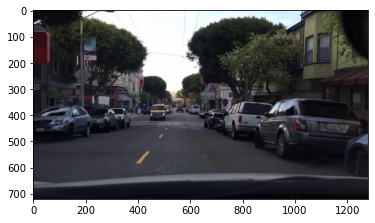

In [28]:
org_img = cv2.imread("C:/Users/moham/Carla/archive/bdd100k/bdd100k/images/10k/test/e89ed929-0899f063.jpg")
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
dimensions = org_img.shape[::-1][1:3]
img = cv2.resize(org_img, (256,256))
small_img = img/255
small_img = small_img[None,:,:]
print(small_img.shape)
plt.imshow(org_img)
plt.show()
# unet_model.summary()

In [29]:
predicted_img = unet_model.predict(small_img)

In [30]:
pred = (predicted_img[0]>0.7).astype(np.uint8)*255

In [31]:
blanks = np.zeros_like(pred).astype(np.uint8)
lane_drawn = np.dstack((blanks, pred, blanks))
image_final = cv2.resize(lane_drawn,dimensions)
final_int = image_final.astype(int)
print(final_int.shape, org_img.shape)
result = cv2.addWeighted(cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB), 1, np.uint8(final_int), 0.8, 0)

(720, 1280, 3) (720, 1280, 3)


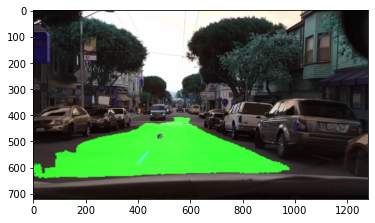

In [32]:
plt.imshow(result)
plt.show()

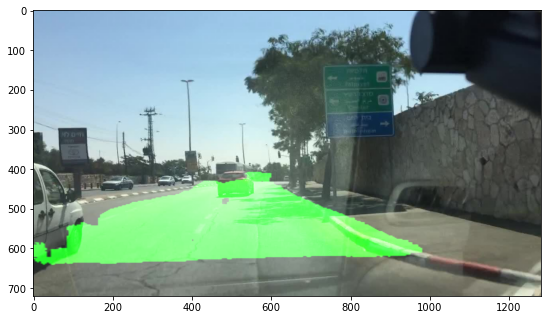

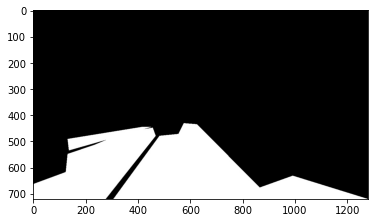

In [34]:
# Testing on an image
import numpy as np
import matplotlib.pyplot as plt
number = "00ecf963-bea6bf0f"
org_img = cv2.imread("C:/Users/moham/Carla/Unet_test_on_data/imgs/"+number+".jpg")
label = cv2.imread("C:/Users/moham/Carla/Unet_test_on_data-labels/imgs/"+number+".jpg")
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
dimensions = org_img.shape[::-1][1:3]
img = cv2.resize(img, (256,256))
small_img = img/255
small_img = small_img[None,:,:]

predicted_img = unet_model.predict(small_img)
pred = (predicted_img[0]>0.7).astype(np.uint8)*255

blanks = np.zeros_like(pred).astype(np.uint8)
lane_drawn = np.dstack((blanks, pred, blanks))
image_final = cv2.resize(lane_drawn,dimensions)
final_int = image_final.astype(int)
result = cv2.addWeighted(org_img, 1, np.uint8(final_int), 0.8, 0)

w = 10
h = 10

fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(result)
plt.show()


fig.add_subplot(rows, columns, 2)
plt.imshow(label)
plt.show()